# Multiclass leaf classification


The present work applies classification algorithms to a leaf data set.
The models' performances are compared.

The outline is as follows:

 * baseline performances with the K-NN
 * multiclass SVM with differents parameters
 * models' performances visualization 
 * best model selection 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Data visualization and processing

In [2]:
# species/margin/shape/texture
leafset = pd.read_csv('leaf_dataset.csv', index_col=0)
leafset.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


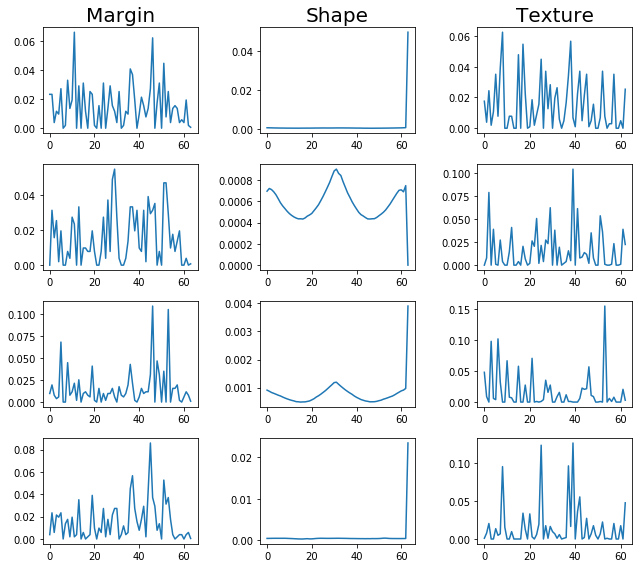

Mean margin =  1.536e-02
Mean shape =   9.379e-04
Mean texture = 1.552e-02


In [3]:
X = leafset.as_matrix(columns=leafset.columns[2:])
margin = X[:, :64]
shape = X[:, 64:128]
texture = X[:, 128:]

# plot some of the features
nb_sample = 4
plt.figure(figsize=(3*nb_sample,8))
for i in range(nb_sample):
    plt.subplot(nb_sample,nb_sample,1+i*nb_sample)
    plt.plot(margin[i])
    if i == 0: plt.title('Margin', fontsize=20)
    plt.subplot(nb_sample,nb_sample,2+i*nb_sample)
    plt.plot(shape[i])
    if i == 0: plt.title('Shape', fontsize=20)
    plt.subplot(nb_sample,nb_sample,3+i*nb_sample)
    plt.plot(texture[i])
    if i == 0: plt.title('Texture', fontsize=20)

plt.tight_layout()
plt.show()

print ("Mean margin =  %.3e" % margin.mean())
print ("Mean shape =   %.3e" % shape.mean())
print ("Mean texture = %.3e" % texture.mean())

In [4]:
def data_preprocessing(leaf_data):
    """
        Data preprocessing:
           * standardization
           * train/test splitting
        
        args: DataFrame 
        return: X_train, X_test, y_train, y_test
    
    """
    le = LabelEncoder()
    le.fit(leaf_data.species) 
    
    # encode species strings
    leaf_data.species = le.transform(leaf_data.species)           
    print("There are %d different species of leaves.\n" % leaf_data.species.max())
    
    # define target (species) and features
    X = leaf_data.iloc[:, 1:]
    Y = leaf_data.iloc[:, 0]
    
    # normalize the features X
    print("Data standardizing...")
    scaler = StandardScaler()
    scaler.fit(X)
    X_scale = scaler.transform(X)
    
    # Split data into train and test sets
    print("Train/test splitting...")
    X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.25, stratify=Y)
    # stratify=Y => each kind of leave is present 
    # in the same proportion in train/test set.
    
    print("OK")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_preprocessing(leafset)

There are 98 different species of leaves.

Data standardizing...
Train/test splitting...
OK


# Classification performance
## Baseline with k-NN classifier

In [5]:
# Baseline with default k-NN classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred) 
print("k-NN classifier accuracy on the test set: %0.4f" % baseline_accuracy)

k-NN classifier accuracy on the test set: 0.9597


In [6]:
# specify the performance for different k
acc = []
for k in range(2, 10):
    knn_k = KNeighborsClassifier(n_neighbors = k)
    knn_k.fit(X_train, y_train)
    y_pred_k = knn_k.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred_k))
    print("Accuracy on the test set for k = %d : %0.4f" % (k, acc[k-2]))
    
best_perf = acc.index(max(acc))+2    
print("\nBest performance obtained with k = %d" % best_perf)    

Accuracy on the test set for k = 2 : 0.9597
Accuracy on the test set for k = 3 : 0.9677
Accuracy on the test set for k = 4 : 0.9677
Accuracy on the test set for k = 5 : 0.9597
Accuracy on the test set for k = 6 : 0.9637
Accuracy on the test set for k = 7 : 0.9597
Accuracy on the test set for k = 8 : 0.9556
Accuracy on the test set for k = 9 : 0.9476

Best performance obtained with k = 3


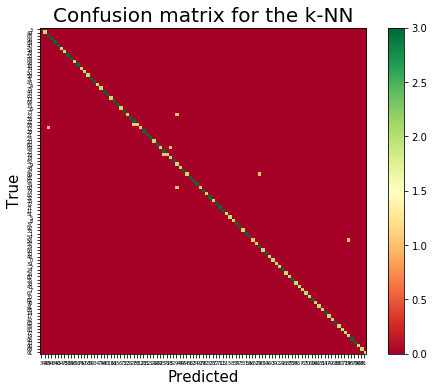

In [7]:
k = best_perf
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_predicted_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_predicted_knn)
cm_knn_df = pd.DataFrame(cm_knn)
cm_knn_df.shape

fig, ax = plt.subplots(figsize=(8,6))
img1 = ax.imshow(cm_knn, cmap=plt.cm.RdYlGn)
classNames = leafset.species.unique()
plt.title('Confusion matrix for the k-NN', size=20)
plt.ylabel('True', size=15)
plt.xlabel('Predicted', size=15)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, size=5)
plt.yticks(tick_marks, classNames, size=5)
fig.colorbar(img1, ax=ax)
plt.show()

The confusion matrix shows that there is only very few values badly predicted.
In what follows we manage to improve this result.

## Multiclass SVM classifier

First, we present the performance of the mutliclass SVM classifier with its default parameters.
Then, we proceed to optimization by a grid search algorithm.

In [8]:
# Default multiclass SVM classifier:
# One-versus-Rest and l2 penalty
clf = LinearSVC(dual=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Multiclass SVM classifier accuracy on the test set: %0.4f" 
      % accuracy_score(y_test, y_pred)) 

Multiclass SVM classifier accuracy on the test set: 0.9677


The default multiclass SVM classifier performs worse than the k-NN classifier, so it has to be tuned to be optimized and outperform the k-NN performances.

In [9]:
# Multiclass SVM classifier with optimal hyper-parameters
lsvm = LinearSVC(dual=False) 
# dual = False => more samples than variables
params = {'C': [0.01, 0.1, 1, 10, 100], 
          'penalty': ['l2', 'l1'], 
          'multi_class': ['ovr', 'crammer_singer']}
# Test hyper-parameters:
    # C: regularization coefficient
    # penalty: regularization norm 
    # multi_class: One-vs-rest or Crammer Singer
    # note: for Crammer Singer method, only l2 penalty is possible
gs = GridSearchCV(lsvm, params, cv=3)

# Training of the models
gs.fit(X_train, y_train) # Takes few minutes ...

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2', 'l1'], 'multi_class': ['ovr', 'crammer_singer']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
# Determine the best parameters
print("Best parameters: \n", gs.best_params_) 

# Accuracy with optimal hyper-parameters
y_pred = gs.predict(X_test)
gs_accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy score with optimal hyper-parameters: %0.4f" % gs_accuracy) 

if baseline_accuracy < gs_accuracy:
    acc_per = 100*(gs_accuracy-baseline_accuracy)/baseline_accuracy
    print(" ========> %0.1f%% better than the baseline accuracy" % acc_per)

Best parameters: 
 {'C': 0.01, 'multi_class': 'crammer_singer', 'penalty': 'l2'}

Accuracy score with optimal hyper-parameters: 0.9798
 ========> 2.1% better than the baseline accuracy


# Select the best model

## Accuracy results 

We compute accuracy for the One-versus-One model and for the One-versus-Rest models with different parameters.
Then we compare the efficiency.

In [11]:
C = np.logspace(-3, 3, 10)

# One-Versus-One
accuracy_ovo = []
for c in C:
    ovoc = OneVsOneClassifier(
        #SVC(C=c, kernel='sigmoid', gamma=0.001, decision_function_shape ='ovo'))   
        SVC(C=c, kernel='sigmoid', 
            gamma=0.001, decision_function_shape ='ovo'))   
    ovoc.fit(X_train, y_train)
    accuracy_ovo.append(ovoc.score(X_test,y_test))
# One-Versus-Rest with l2-norm 
ovr_clf2 = LinearSVC(dual=False, penalty='l2', multi_class='ovr')
accuracy_ovr2 = []
for c in C:
    ovr_clf2.set_params(C=c)
    ovr_clf2.fit(X_train, y_train)
    accuracy_ovr2.append(ovr_clf2.score(X_test, y_test))
# Crammer-Singer with l2-norm 
cs_clf2 = LinearSVC(dual=False, penalty='l2', multi_class='crammer_singer')
accuracy_cs2 = []
for c in C:
    cs_clf2.set_params(C=c)
    cs_clf2.fit(X_train, y_train)
    accuracy_cs2.append(cs_clf2.score(X_test, y_test))
# One-Versus-Rest with l1-norm 
ovr_clf1 = LinearSVC(dual=False, penalty='l1', multi_class='ovr')
accuracy_ovr1 = []
for c in C:
    ovr_clf1.set_params(C=c)
    ovr_clf1.fit(X_train, y_train)
    accuracy_ovr1.append(ovr_clf1.score(X_test, y_test))

## Plotting results

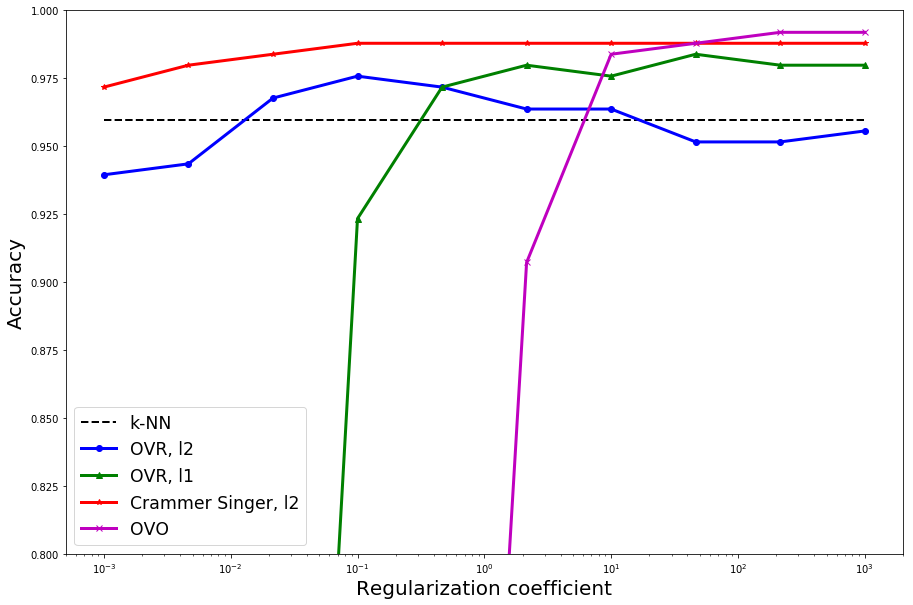

In [12]:
plt.figure(figsize=(15, 10))
plt.plot([min(C), max(C)], [baseline_accuracy, baseline_accuracy], 
         label='k-NN', color='black', linestyle='--', linewidth=2)
plt.plot(C, accuracy_ovr2, 'bo-', label='OVR, l2', linewidth=3) 
plt.plot(C, accuracy_ovr1, 'g^-',label='OVR, l1', linewidth=3)
plt.plot(C, accuracy_cs2, 'r*-', label='Crammer Singer, l2', linewidth=3)
plt.plot(C, accuracy_ovo, 'mx-', label='OVO', linewidth=3)
plt.xscale('log')
plt.xlabel('Regularization coefficient', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(loc='best', fontsize = 'xx-large')
plt.axis('tight')
plt.ylim([0.8, 1])
plt.rc('axes', labelsize=20)    
plt.show()


## Conclusion:

* The value of the regularization coefficient much influences the One-versus-Rest methods, while it less influences the Crammer-Singer method.
* The Crammer Singer method clearly better performs than the One-versus-Rest method. 

* The One-versus-One method strongly depends on the value of the regularization parameter:
  * the OVO method performs bad for low values of C.
  * the OVO method performs better than the others for the optimal value of C.
